# How do we take the full unique phenotype list and create a slimed down version


In [1]:
import pandas as pd
phenotypes_df = pd.read_csv("wormbase_data/phenotypes_WS293.csv")
phenotypes = phenotypes_df['Name'].tolist()
phenotypes_df

,ID,Name,Evidence
0,WBPhenotype:0000000,chromosome instability,rnai
1,WBPhenotype:0000001,body posture variant,allele
2,WBPhenotype:0000002,kinker,rnai
3,WBPhenotype:0000004,constitutive egg laying,allele
4,WBPhenotype:0000005,hyperactive egg laying,allele
...,...,...,...
2159,WBPhenotype:0006001,squashed vulva,allele
2160,WBPhenotype:0008001,embryonic cell fate specification variant,rnai
2161,WBPhenotype:0010001,cell growth variant,rnai
2162,WBPhenotype:0010003,cell corpse appearance delayed,allele


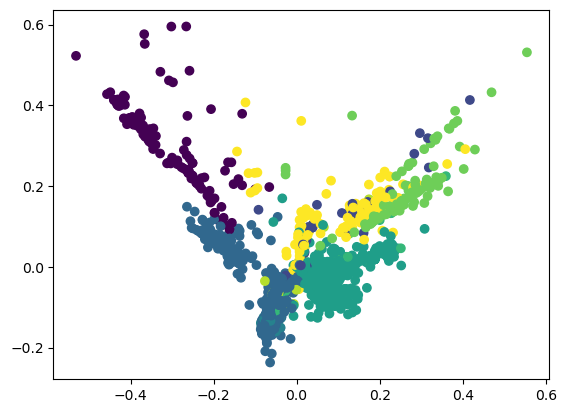

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Preprocess text
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(phenotypes)

# K-Means clustering
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

# Get cluster labels
labels = kmeans.labels_

# Visualize clusters
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

# Calculate cosine similarity
similarity_matrix = cosine_similarity(X)

In [3]:
# Create a dictionary to store phenotype names by cluster
cluster_phenotypes = {}
for i, label in enumerate(labels):
    if label not in cluster_phenotypes:
        cluster_phenotypes[label] = [phenotypes[i]]
    else:
        cluster_phenotypes[label].append(phenotypes[i])

# Print phenotype names by cluster
total =0
for cluster, phenotypes_in_cluster in sorted(cluster_phenotypes.items()):
    print(f"Cluster {cluster+1}:")
    print(len(phenotypes_in_cluster))
    total +=len(phenotypes_in_cluster)
    for phenotype in phenotypes_in_cluster:
         print(f"- {phenotype}")
    print()
    
print(total)

Cluster 1:
115
- one cell arrest early emb
- egg size defective early emb
- pace of P lineage defective early emb
- early larval arrest
- early larval lethal
- general pace of development defective early emb
- no cleavage furrow first division early emb
- pleiotropic defects severe early emb
- embryo osmotic integrity defective early emb
- comma arrest emb
- early eggs laid
- spindle assembly defective early emb
- asymmetric cell division defective early emb
- spindle defective early emb
- spindle orientation defective early emb
- spindle position orientation defective early emb
- spindle position defective early emb
- spindle elongation integrity defective early emb
- integrity of membranous organelles defective early emb
- cytoplasmic structure defective early emb
- cytoplasmic appearance defective early emb
- centrosome attachment defective early emb
- sister chromatid segregation defective early emb
- passage through meiosis defective early emb
- polar body extrusion defective earl

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter


def generate_best_term(terms):
    # Initialize lemmatizer and stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Tokenize and lemmatize terms
    tokenized_terms = [word_tokenize(term) for term in terms]
    flattened_terms = [word for sublist in tokenized_terms for word in sublist]
    lemmatized_terms = [lemmatizer.lemmatize(word) for word in flattened_terms]

    # Filter out stop words
    filtered_terms = [word for word in lemmatized_terms if word not in stop_words]

    # Count term frequencies
    term_freq = Counter(filtered_terms)

    # Get most common term
    best_term = term_freq.most_common(1)[0][0]

    return best_term


temp_dict = {}
for key, value in cluster_phenotypes.items():
    best_term = generate_best_term(value)
    temp_dict[best_term] = value
    
cluster_phenotypes = temp_dict


In [5]:
def save_to_excel(data, file_nm):
    # Convert dictionary to DataFrame
    df = pd.DataFrame({k: pd.Series(v) for k, v in data.items()})

    # Fill missing values with empty string (optional)
    df = df.fillna('')

    # Write to Excel file
    df.to_excel(file_nm, index=False)

save_to_excel(cluster_phenotypes, 'clusters.xlsx')

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')



In [ ]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
print(len(stop_words))

In [ ]:
def remove_stop_words(phenotype, stop_words):
    stop_words_set = set(word.lower() for word in stop_words)
    
    words = phenotype.split()
    filtered_words = [word for word in words if word.lower() not in stop_words_set]

    return ' '.join(filtered_words)

phenotypes_df['Name_short'] = phenotypes_df['Name'].apply(lambda x: remove_stop_words(x, stop_words))

phenotypes_df['changed'] = phenotypes_df['Name'] != phenotypes_df['Name_short']

print(phenotypes_df['changed'].value_counts())
phenotypes_df

In [ ]:
from nltk.stem import WordNetLemmatizer

def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word)

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatize_word(word) for word in words]
    return ' '.join(lemmatized_words)

phenotypes_df['Name_lemmatized'] = phenotypes_df['Name_short'].apply(lambda x: lemmatize_text(x))

phenotypes_df['changed2'] = phenotypes_df['Name_short'] != phenotypes_df['Name_lemmatized']

print(phenotypes_df['changed2'].value_counts())
phenotypes_df


# BioBERT

In [1]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BioBERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-v1.1')
model = BertModel.from_pretrained('dmis-lab/biobert-v1.1')

# Define classification function
def classify_text(text):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Forward pass
    outputs = model(**inputs)

    # Get pooled output (representation of entire text)
    pooled_output = outputs.pooler_output

    # Simple classification (you can add custom classification layer)
    classification = torch.argmax(pooled_output)

    return classification

# Test classification function
text = "reduced pharyngeal pumping"
classification = classify_text(text)
print(f"Classification: {classification}")

/Users/dan/miniforge3/envs/dan-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Classification: 232


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load pre-trained PubMedBERT model and tokenizer
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=8)

# Define classification function
def classify_text(text):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Forward pass
    outputs = model(**inputs)

    # Get predicted class probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)

    # Get predicted class index
    classification = torch.argmax(probs)

    return classification, probs

# Test classification function
text = "reduced pharyngeal pumping"
classification, probs = classify_text(text)
print(f"Classification: {classification}")
print(f"Class Probabilities: {probs}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification: 7
Class Probabilities: tensor([[0.1489, 0.1214, 0.1380, 0.0852, 0.1064, 0.0921, 0.1396, 0.1684]],
       grad_fn=<SoftmaxBackward0>)
